# Eksperymenty z boostingiem na danych ubepieczeniowych

## Sprawdzenie zasobów

In [1]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

In [2]:
!pip install git+https://github.com/krzpiesiewicz/timeseries.git@16a3e149007bbe58207024d153a8bfeb076388ac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/krzpiesiewicz/timeseries.git (to revision 16a3e149007bbe58207024d153a8bfeb076388ac) to /tmp/pip-req-build-toxxqfxe
  Running command git clone --filter=blob:none --quiet https://github.com/krzpiesiewicz/timeseries.git /tmp/pip-req-build-toxxqfxe
  Running command git rev-parse -q --verify 'sha^16a3e149007bbe58207024d153a8bfeb076388ac'
  Running command git fetch -q https://github.com/krzpiesiewicz/timeseries.git 16a3e149007bbe58207024d153a8bfeb076388ac
  Resolved https://github.com/krzpiesiewicz/timeseries.git to commit 16a3e149007bbe58207024d153a8bfeb076388ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.3 MB/s eta 0:00:00
  Created wheel for timeseries: filename=timeseries-0.0.3-py3-none-any.whl size=38012 sha256=654f363c25413

In [3]:
!pip install git+https://github.com/krzpiesiewicz/concise-analysis.git@edb815abd94720120144e690f04c81db136ac853

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/krzpiesiewicz/concise-analysis.git (to revision edb815abd94720120144e690f04c81db136ac853) to /tmp/pip-req-build-ke89fuuz
  Running command git clone --filter=blob:none --quiet https://github.com/krzpiesiewicz/concise-analysis.git /tmp/pip-req-build-ke89fuuz
  Running command git rev-parse -q --verify 'sha^edb815abd94720120144e690f04c81db136ac853'
  Running command git fetch -q https://github.com/krzpiesiewicz/concise-analysis.git edb815abd94720120144e690f04c81db136ac853
  Running command git checkout -q edb815abd94720120144e690f04c81db136ac853
  Resolved https://github.com/krzpiesiewicz/concise-analysis.git to commit edb815abd94720120144e690f04c81db136ac853
  Preparing metadata (setup.py) ... done
  Created wheel for concise-analysis: filename=concise_analysis-0.0.1-py3-none-any.whl size=10249 sha256=accd216e8a7bcc533daf0e6476a91ed85e15baa1379bb551aef03fe343d3

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns

from concise_analysis.models import (
    ClassificationsCollector,
    RegressionPredictionsCollector,
    collect_ensemble_predictions,
    get_scores,
    get_cv_scores,
    print_scores,
    print_importances,
    forests_importances,
)

from timeseries import plot_ts

## Dane i analiza

In [5]:
!wget https://students.mimuw.edu.pl/~kp385996/ai-insurance/dane.zip
!unzip dane.zip

--2023-06-01 15:11:31--  https://students.mimuw.edu.pl/~kp385996/ai-insurance/dane.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7048389 (6.7M) [application/zip]
Saving to: ‘dane.zip’

dane.zip            100%[===================>]   6.72M  33.5MB/s    in 0.2s    

2023-06-01 15:11:31 (33.5 MB/s) - ‘dane.zip’ saved [7048389/7048389]

Archive:  dane.zip
   creating: dane/
  inflating: dane/freMTLP2freq.csv   
  inflating: dane/freMTLP2sev.csv    


In [6]:
full_data = pd.read_csv('dane/freMTLP2freq.csv')

In [7]:
full_data.head()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1.0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [8]:
full_data.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [9]:
missing = False

for col in full_data.columns:
    nans = np.sum(full_data[col].isna())
    if nans > 0:
        print(f"{nans} missing values in column {col}")
        missing = True

if not missing:
    print("No missing values")

No missing values


In [10]:
data = full_data.drop(["IDpol", "ClaimNb", "Exposure"], axis=1)

# zmienna objaśniana (target)
data["target"] = full_data["ClaimNb"] / full_data["Exposure"]

### Odstające wartości zmiennej objaśnianej

In [11]:
n = len(full_data)
cnts = pd.DataFrame(full_data.groupby("ClaimNb").ClaimNb.count())
cnts.columns = ["Samples"]
cnts["Percentage"] = round(100 * cnts.Samples / n, 2)
cnts

,Samples,Percentage
ClaimNb,,
0,643953,94.98
1,32178,4.75
2,1784,0.26
3,82,0.01
4,7,0.00
5,2,0.00
6,1,0.00
8,1,0.00
9,1,0.00


In [12]:
fig = px.histogram(
    data.target[data.target > 0.0001],
    title="target = ClaimNb / Exposure",
    log_y=True,
    
)
fig.update_traces(opacity=0.75)
fig.show()

In [13]:
def target_percs(data):
    vals_and_ops = [(0, "≥"), (0, ">"), (1, "≥"), (1, ">")] + list(zip([1.5, 2, 3, 5, 7] + list(range(10, 110, 10)) + [150, 200, 250, 300, 350, 400], [">"] * 100))
    n = len(data)
    rows = []
    for t, op in vals_and_ops:
        if op == "≥":
            cnt = (data.target >= t).sum()
        else:
            cnt = (data.target > t).sum()
        thrhs = f"target {op} {t:3}".replace(" ", " ")
        rows.append((thrhs, cnt, round(100 * cnt/n, 2)))
    df = pd.DataFrame(rows, columns=["Threshold", "Samples", "Percentage"])
    return df


target_percs(data)

,Threshold,Samples,Percentage
0,target ≥ 0,678013,100.00
1,target > 0,34060,5.02
2,target ≥ 1,34012,5.02
3,target > 1,23337,3.44
4,target > 1.5,17115,2.52
5,target > 2,12913,1.90
6,target > 3,8958,1.32
7,target > 5,5473,0.81
8,target > 7,4349,0.64
9,target > 10,3106,0.46


Jak widać powyżej mamy w zbiorze danych obserwacje mocno odstające

## Podział danych na zbiory: treningowy, walidacyjny i testowy

In [14]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(
    data["target"],
    test_size=0.3,
    random_state=20230325,
)
train_ids = train_ids.index
test_ids = test_ids.index
train_data = data.loc[train_ids]
test_data = data.loc[test_ids]

In [15]:
def make_X_y(
    data,
    target,
    selected_ftrs=None,
    dropped_ftrs=None,
):
    y = data[target].copy()

    df = data.filter(selected_ftrs) if selected_ftrs is not None else data
    df = df.copy()

    if dropped_ftrs is not None:
        for ftr in dropped_ftrs:
            if ftr in df.columns:
                df.drop(ftr, axis=1, inplace=True)
    
    X = df.drop(target, axis=1) if target in df.columns else df
    return X, y

In [16]:
target_percs(train_data)

,Threshold,Samples,Percentage
0,target ≥ 0,474609,100.00
1,target > 0,23892,5.03
2,target ≥ 1,23859,5.03
3,target > 1,16351,3.45
4,target > 1.5,11965,2.52
5,target > 2,9039,1.90
6,target > 3,6254,1.32
7,target > 5,3828,0.81
8,target > 7,3043,0.64
9,target > 10,2161,0.46


## Transformacja danych i selekcja cech

### Zmienne kategoryczne i one-hot encoding

In [17]:
cat_ftrs = []

for ftr in data.loc[train_ids].columns:
    if data.loc[train_ids][ftr].dtype is np.dtype("O"):
        vals = np.unique(data.loc[train_ids][ftr])
        print(f"Feature:  {ftr:13} –   {len(vals):3} distinct values")
        cat_ftrs.append(ftr)

cat_ftrs = pd.Index(cat_ftrs)

Feature:  VehBrand      –    11 distinct values
Feature:  VehGas        –     2 distinct values
Feature:  Area          –     6 distinct values
Feature:  Region        –    21 distinct values


In [18]:
num_ftrs = data.loc[train_ids].columns.drop(cat_ftrs).drop("target")
num_ftrs

Index(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density'], dtype='object')

In [19]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(min_frequency=100, drop="if_binary", sparse_output=False)
ohe.fit(data.loc[train_ids, cat_ftrs])
feature_names = ohe.get_feature_names_out(cat_ftrs)


def ohe_transform(data):
    return pd.concat(
        [
            data.drop(cat_ftrs, axis=1),
            pd.DataFrame(
                ohe.transform(data.loc[:, cat_ftrs]),
                columns=feature_names,
                index=data.index,
            ).astype(int),
        ],
        axis=1,
    )


train_data = ohe_transform(data.loc[train_ids])
test_data = ohe_transform(data.loc[test_ids])

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data.loc[train_ids, num_ftrs])


def scale_transform(data):
    return pd.concat(
        [
            pd.DataFrame(
                scaler.transform(data.loc[:, num_ftrs]),
                columns=scaler.get_feature_names_out(),
                index=data.index
            ),
            data.drop(num_ftrs, axis=1)
        ],
        axis=1,
    )


train_data = scale_transform(train_data)
test_data = scale_transform(test_data)

In [21]:
train_data.head()

,VehPower,VehAge,DrivAge,BonusMalus,Density,target,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_Ile-de-France,Region_Languedoc-Roussillon,Region_Limousin,Region_Midi-Pyrenees,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes
505423,0.264966,-1.067795,-0.673054,-0.559989,-0.295194,0.0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
103940,2.215011,-0.714807,0.246404,-0.623981,-0.265678,1.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
305278,0.264966,-1.067795,0.246404,-0.623981,-0.327738,0.0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
23576,-0.222546,0.873639,-0.036507,-0.623981,-0.244738,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
389642,0.264966,2.638579,0.317131,-0.623981,-0.401404,1.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


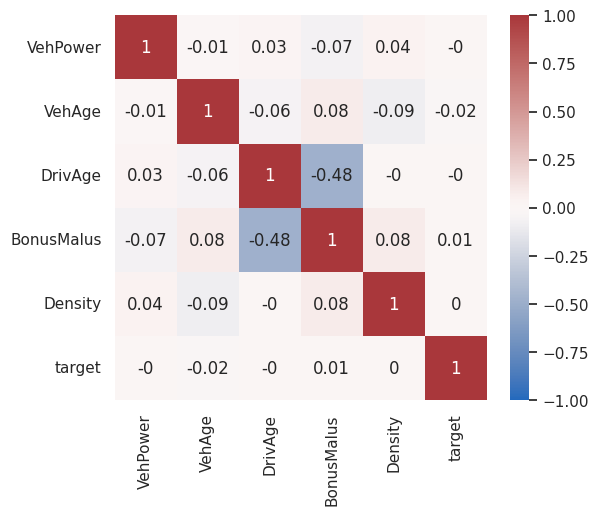

In [22]:
corr_mat = data.loc[train_ids].corr(numeric_only=True).round(2)
sns.set(rc={"figure.figsize": (6, 5)})
fig = sns.heatmap(corr_mat, cmap="vlag", vmin=-1, vmax=1, annot=True)

In [23]:
corr_mat = train_data.corr(numeric_only=True).round(2)

In [24]:
corr_mat.filter(like="VehBrand", axis=0).filter(like="target", axis=1)

,target
VehBrand_B1,-0.01
VehBrand_B10,-0.00
VehBrand_B11,-0.00
VehBrand_B12,0.03
VehBrand_B13,-0.00
VehBrand_B14,-0.00
VehBrand_B2,-0.01
VehBrand_B3,-0.00
VehBrand_B4,-0.00
VehBrand_B5,-0.00


In [25]:
corr_mat.filter(like="VehGas", axis=0).filter(like="target", axis=1)

,target
VehGas_Regular,0.01


In [26]:
corr_mat.filter(like="Area", axis=0).filter(like="target", axis=1)

,target
Area_A,-0.00
Area_B,-0.00
Area_C,-0.00
Area_D,0.00
Area_E,0.00
Area_F,0.01


In [27]:
corr_mat.filter(like="Region", axis=0).filter(like="target", axis=1)

,target
Region_Alsace,0.00
Region_Aquitaine,-0.00
Region_Auvergne,-0.00
Region_Basse-Normandie,-0.00
Region_Bourgogne,0.00
Region_Bretagne,-0.00
Region_Centre,-0.01
Region_Champagne-Ardenne,0.01
Region_Corse,0.00
Region_Franche-Comte,0.00


In [28]:
counts_non_zeros = train_data[train_data > 0.1].count().sort_values(ascending=False)

In [29]:
counts_non_zeros.filter(like="VehBrand")

VehBrand_B12    116167
VehBrand_B1     114050
VehBrand_B2     111831
VehBrand_B3      37263
VehBrand_B5      24437
VehBrand_B6      19956
VehBrand_B4      17672
VehBrand_B10     12379
VehBrand_B11      9527
VehBrand_B13      8475
VehBrand_B14      2852
dtype: int64

In [30]:
counts_non_zeros.filter(like="VehGas")

VehGas_Regular    242249
dtype: int64

In [31]:
counts_non_zeros.filter(like="Area")

Area_C    134550
Area_D    106121
Area_E     95931
Area_A     72843
Area_B     52532
Area_F     12632
dtype: int64

In [32]:
counts_non_zeros.filter(like="Region")

Region_Centre                         112636
Region_Rhone-Alpes                     59358
Region_Provence-Alpes-Cotes-D'Azur     55427
Region_Ile-de-France                   48922
Region_Bretagne                        29424
Region_Nord-Pas-de-Calais              28029
Region_Pays-de-la-Loire                26948
Region_Languedoc-Roussillon            25256
Region_Aquitaine                       21934
Region_Poitou-Charentes                13253
Region_Midi-Pyrenees                   11979
Region_Basse-Normandie                  7575
Region_Bourgogne                        7453
Region_Haute-Normandie                  6166
Region_Picardie                         5598
Region_Auvergne                         3731
Region_Limousin                         3190
Region_Corse                            3119
Region_Champagne-Ardenne                2116
Region_Alsace                           1570
Region_Franche-Comte                     925
dtype: int64

In [33]:
train_select_ids, _ = train_test_split(
    train_data["target"],
    train_size=0.3,
    random_state=20230520,
)

train_select_ids = train_select_ids.index

In [34]:
train_select_data = train_data.loc[train_select_ids]

X_select_train, y_select_train = make_X_y(train_select_data, target="target")

rng = np.random.default_rng(323424342)
X_select_train["RandomUniform1"] = rng.uniform(-1, 1, len(X_select_train))
X_select_train["RandomUniform2"] = rng.uniform(-1, 1, len(X_select_train))
X_select_train["RandomNormal1"] = rng.normal(0, 1, len(X_select_train))
X_select_train["RandomNormal2"] = rng.normal(0, 1, len(X_select_train))
X_select_train["RandomBern1"] = rng.choice([0,1], len(X_select_train))
X_select_train["RandomBern2"] = rng.choice([0,1], len(X_select_train))

In [35]:
X_select_train

,VehPower,VehAge,DrivAge,BonusMalus,Density,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,VehBrand_B13,...,Region_Picardie,Region_Poitou-Charentes,Region_Provence-Alpes-Cotes-D'Azur,Region_Rhone-Alpes,RandomUniform1,RandomUniform2,RandomNormal1,RandomNormal2,RandomBern1,RandomBern2
264876,-0.222546,0.344157,-1.946150,2.575587,-0.010370,0,0,0,0,1,...,0,0,0,1,-0.903770,-0.636921,-0.341880,0.124382,0,1
621237,-1.197569,-0.891301,1.236589,-0.623981,-0.306799,0,0,0,1,0,...,0,0,0,0,-0.824791,0.661827,0.286007,0.772500,1,1
596309,-0.222546,1.579615,1.165861,-0.304024,-0.368355,0,0,0,0,0,...,0,0,0,0,-0.284612,-0.625073,-0.494058,0.245110,0,0
534671,1.239989,2.462085,-0.248689,-0.623981,-0.281571,0,0,0,0,0,...,0,1,0,0,0.124704,0.632373,1.231003,0.308465,1,0
474804,0.264966,0.697145,0.104949,-0.559989,0.384195,0,0,0,0,0,...,0,0,1,0,-0.633911,0.470009,0.720843,0.186746,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500062,0.752477,-0.891301,0.882951,-0.623981,-0.298979,0,0,0,1,0,...,0,0,1,0,0.137405,-0.952913,-0.046632,0.934655,0,0
190724,-0.222546,-0.891301,-0.248689,-0.623981,0.384195,0,0,0,0,0,...,0,0,1,0,0.278930,-0.462267,2.829509,-0.403957,1,0
418207,0.264966,1.226627,-0.814509,1.615717,-0.426632,1,0,0,0,0,...,0,0,0,1,0.237998,0.940280,-2.233422,-0.461911,0,0
141400,-1.197569,-1.067795,-1.592512,1.615717,6.358938,0,0,0,0,0,...,0,0,0,0,-0.851669,0.369507,0.038414,-0.386764,1,1


### Ranking cech według lasu losowego

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    max_depth=10,
    max_features=10,
    n_estimators=400,
    min_samples_leaf=100,
    max_samples=0.5,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=False,
)

forests = []
select_baseline_scores = get_cv_scores(
    RandomForestRegressor,
    hparams=forest_hparams,
    X=X_select_train, y=y_select_train,
    classif=False, metrics = ["mae", "mse", "medae"],
    list_to_save_models=forests, folds=5
)
print_scores(select_baseline_scores, show_stds=True)
names=X_select_train.keys()
importances, importances_stds, indices, names = forests_importances(forests, names=names)
print_importances(importances, importances_stds, indices, names, model_name="Random forest")

train_mae:  0.4965       train_mse:  25.3862       train_medae:  0.1785
           ±0.0046                   ±0.9775                    ±0.0010

val_mae:    0.4987       val_mse:    25.6023       val_medae:    0.1791
           ±0.0082                   ±3.9460                    ±0.0010


Random forest features ranking:
 1. import. 0.219 (std: 0.099)  –  VehAge
 2. import. 0.106 (std: 0.109)  –  RandomNormal2
 3. import. 0.103 (std: 0.118)  –  RandomUniform2
 4. import. 0.094 (std: 0.103)  –  Density
 5. import. 0.086 (std: 0.085)  –  RandomUniform1
 6. import. 0.070 (std: 0.076)  –  RandomNormal1
 7. import. 0.065 (std: 0.072)  –  DrivAge
 8. import. 0.050 (std: 0.069)  –  VehPower
 9. import. 0.041 (std: 0.035)  –  VehBrand_B12
10. import. 0.033 (std: 0.038)  –  VehGas_Regular
11. import. 0.030 (std: 0.039)  –  BonusMalus
12. import. 0.011 (std: 0.024)  –  RandomBern2
13. import. 0.010 (std: 0.024)  –  RandomBern1
14. import. 0.008 (std: 0.022)  –  Area_C
15. import. 0.007 (std: 0.0

### Zmniejszenie wysokich wartości zmiennej target

In [36]:
def log_transform(y):
    return np.log(1 + (np.e - 1) * y)


def inv_log_transform(log_1py):
    return (np.exp(log_1py) - 1) / (np.e - 1)

In [37]:
target_percs(log_transform(train_data))

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning:

invalid value encountered in log



,Threshold,Samples,Percentage
0,target ≥ 0,474609,100.00
1,target > 0,23892,5.03
2,target ≥ 1,23859,5.03
3,target > 1,16351,3.45
4,target > 1.5,9031,1.90
5,target > 2,5163,1.09
6,target > 3,2149,0.45
7,target > 5,256,0.05
8,target > 7,3,0.00
9,target > 10,0,0.00


In [38]:
class LogModelWrapper():
    def __init__(self, model, **kwargs):
        self.model = model
    
    def predict(self, X, *args, **kwargs):
        log_1py = self.model.predict(X, *args, **kwargs)
        y = inv_log_transform(log_1py)
        y[y < 0] = 0
        return y

    def fit(self, X, y, *args, **kwargs):
        log_1py = log_transform(y)
        log_1py[log_1py < 0] = 0
        self.model.fit(X, log_1py, *args, **kwargs)

        if hasattr(self.model, "feature_importances_") and self.model.feature_importances_ is not None:
            self.feature_importances_ = self.model.feature_importances_
        if hasattr(self.model, "estimators_") and self.model.estimators_ is not None:
            self.estimators_ = self.model.estimators_


def get_log_model_wrapper_constructor(model_constr, **wrapper_kwargs):
    
    def create_model(*args, **kwargs):
        model = model_constr(*args, **kwargs)
        return LogModelWrapper(model, **wrapper_kwargs)

    return create_model


from sklearn.metrics import mean_squared_error

def mse_log(y_true, y_pred):
    return mean_squared_error(log_transform(y_true), log_transform(y_pred))


log_mse_scoring = {
    "name": "log_mse",
    "pred_type": "pred",
    "scoring": mse_log,
    "res_type": float,
}

### Ranking cech według lasu losowego na podstawie zmniejszonych wartości zmiennej target

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    max_depth=10,
    max_features=10,
    n_estimators=400,
    min_samples_leaf=100,
    max_samples=0.5,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=False,
)

forests = []
select_baseline_scores = get_cv_scores(
    get_log_model_wrapper_constructor(RandomForestRegressor),
    hparams=forest_hparams,
    X=X_select_train, y=y_select_train,
    classif=False, metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring],
    list_to_save_models=forests, folds=5
)
print_scores(select_baseline_scores, show_stds=True)
names=X_select_train.keys()
importances, importances_stds, indices, names = forests_importances(forests, names=names)
print_importances(importances, importances_stds, indices, names, model_name="Random forest")

train_mae:  0.3096       train_mse:  25.7487       train_medae:  0.0413       train_log_mse:  0.1523
           ±0.0026                   ±0.9888                    ±0.0001                      ±0.0005

val_mae:    0.3100       val_mse:    25.7552       val_medae:    0.0414       val_log_mse:    0.1537
           ±0.0100                   ±3.9550                    ±0.0001                      ±0.0018


Random forest features ranking:
 1. import. 0.297 (std: 0.090)  –  VehAge
 2. import. 0.112 (std: 0.045)  –  BonusMalus
 3. import. 0.077 (std: 0.063)  –  VehGas_Regular
 4. import. 0.071 (std: 0.031)  –  DrivAge
 5. import. 0.068 (std: 0.054)  –  VehPower
 6. import. 0.061 (std: 0.047)  –  VehBrand_B12
 7. import. 0.051 (std: 0.026)  –  RandomNormal2
 8. import. 0.050 (std: 0.026)  –  Density
 9. import. 0.049 (std: 0.026)  –  RandomUniform1
10. import. 0.047 (std: 0.024)  –  RandomNormal1
11. import. 0.045 (std: 0.024)  –  RandomUniform2
12. import. 0.008 (std: 0.009)  –  RandomBern2


### Wybór cech

Na podstawie drugiego rankingu

In [ ]:
ftrs_cnt = 10
print_importances(importances, importances_stds, indices, names, max_ftrs=ftrs_cnt, model_name="Random forest")

Random forest features ranking:
 1. import. 0.297 (std: 0.090)  –  VehAge
 2. import. 0.112 (std: 0.045)  –  BonusMalus
 3. import. 0.077 (std: 0.063)  –  VehGas_Regular
 4. import. 0.071 (std: 0.031)  –  DrivAge
 5. import. 0.068 (std: 0.054)  –  VehPower
 6. import. 0.061 (std: 0.047)  –  VehBrand_B12
 7. import. 0.051 (std: 0.026)  –  RandomNormal2
 8. import. 0.050 (std: 0.026)  –  Density
 9. import. 0.049 (std: 0.026)  –  RandomUniform1
10. import. 0.047 (std: 0.024)  –  RandomNormal1



In [ ]:
selected_ftrs_idx = pd.Series(indices[:8])
selected_ftrs = names[selected_ftrs_idx].drop("RandomNormal2")
selected_ftrs

Index(['VehAge', 'BonusMalus', 'VehGas_Regular', 'DrivAge', 'VehPower',
       'VehBrand_B12', 'Density'],
      dtype='object')

In [39]:
selected_ftrs= pd.Index(['VehAge', 'BonusMalus', 'VehGas_Regular', 'DrivAge', 'VehBrand_B12',
       'VehPower', 'Density'])

## hyperopt

In [40]:
X_train, y_train = make_X_y(train_data, target="target", selected_ftrs=selected_ftrs)
X_test, y_test = make_X_y(test_data, target="target", selected_ftrs=selected_ftrs)

In [41]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
from functools import partial


def objective(
    hparams,
    model_constructor,
    X,
    y,
    get_model_hparams,
    baseline_select_scores=None,
    const_hparams=None,
    hpopt_results=None,
):
    if const_hparams is None:
        const_hparams = {}
    model_hparams = get_model_hparams(hparams, const_hparams)
    scores = get_cv_scores(model_constructor,
                           hparams=model_hparams,
                           X=X_train, y=y_train,
                           classif=False,
                           metrics = ["mae", "mse", "medae"],
                           extra_metrics=[log_mse_scoring],
                           folds=5)
    loss = (scores["val"]["mae"]["mean"] + 0.25 * scores["val"]["mae"]["std"]
            + 0.002 * (scores["val"]["mse"]["mean"] + 0.25 * scores["val"]["mse"]["std"]))
    str_buffer = print_scores(
        scores, baseline_select_scores, return_str=True, show_stds=True
    )
    str_buffer += f"loss: {loss:.7}, hparams: {hparams}\n"
    str_buffer += "_" * 100 + "\n"
    print(str_buffer)
    if hpopt_results is not None:
        hpopt_results.append(
            (
                loss,
                scores["val"]["mae"]["mean"],
                scores["val"]["mse"]["mean"],
                scores,
                hparams.copy(),
            )
        )
    return {"loss": loss, "status": STATUS_OK}

## Las losowy jako podstawowy punkt odniesienia

In [56]:
from sklearn.ensemble import RandomForestRegressor

random_forest_constructor = get_log_model_wrapper_constructor(RandomForestRegressor)

In [ ]:
forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    max_depth=10,
    n_estimators=100,
    min_samples_leaf=100,
    max_samples=0.5,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=False,
)

select_baseline_scores = get_cv_scores(
    random_forest_constructor,
    hparams=forest_hparams,
    X=X_train, y=y_train,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring],
    folds=5
)
print_scores(select_baseline_scores, show_stds=True)

train_mae:  0.3132       train_mse:  24.0314       train_medae:  0.0403       train_log_mse:  0.1526
           ±0.0018                   ±0.5005                    ±0.0001                      ±0.0004

val_mae:    0.3136       val_mse:    24.0395       val_medae:    0.0404       val_log_mse:    0.1539
           ±0.0070                   ±2.0038                    ±0.0001                      ±0.0016




In [ ]:
select_baseline_scores

{'train': {'mae': {'mean': 0.3131813303766961, 'std': 0.001776823335351016},
  'mse': {'mean': 24.031406767423963, 'std': 0.5005212020267361},
  'medae': {'mean': 0.04032867811032228, 'std': 8.774524085147492e-05},
  'log_mse': {'mean': 0.15258850442507407, 'std': 0.0003984710065413553}},
 'val': {'mae': {'mean': 0.3136036430545232, 'std': 0.007003844868124359},
  'mse': {'mean': 24.039484568110613, 'std': 2.00379133021394},
  'medae': {'mean': 0.040367892319211944, 'std': 8.79738099192572e-05},
  'log_mse': {'mean': 0.1539189439005762, 'std': 0.0016098368499815985}}}

In [42]:
select_baseline_scores = {'train': {'mae': {'mean': 0.3131813337780228, 'std': 0.0017768221141418149},
  'mse': {'mean': 24.031406719333642, 'std': 0.5005211630505146},
  'medae': {'mean': 0.04032873330272821, 'std': 8.771181235182051e-05},
  'log_mse': {'mean': 0.152588496636708, 'std': 0.0003984662917213312}},
 'val': {'mae': {'mean': 0.31360363316081213, 'std': 0.007003855203455467},
  'mse': {'mean': 24.0394845549298, 'std': 2.003791362386155},
  'medae': {'mean': 0.040367867201675095, 'std': 8.797882403571163e-05},
  'log_mse': {'mean': 0.15391893878837154, 'std': 0.0016098437774595107}}}

### Strojenie hiperparametrów lasu losowego

In [47]:
def get_random_forest_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)

    if "criterion" in hparams:
        dct["criterion"] = hparams["criterion"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "max_features" in hparams:
        dct["max_features"] = int(hparams["max_features"])

    if "min_samples_leaf" in hparams:
        dct["min_samples_leaf"] = int(hparams["min_samples_leaf"])

    if "min_impurity_decrease" in hparams:
        dct["min_impurity_decrease"] = hparams["min_impurity_decrease"]

    if "ccp_alpha" in hparams:
        dct["ccp_alpha"] = hparams["ccp_alpha"]

    if "max_samples" in hparams:
        dct["max_samples"] = hparams["max_samples"]

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])

    if "n_jobs" in hparams:
        dct["n_jobs"] = int(hparams["n_jobs"])

    if "random_state" in hparams:
        dct["random_state"] = hparams["random_state"]

    if "bootstrap" in hparams:
        dct["bootstrap"] = hparams["bootstrap"]

    if "oob_score" in hparams:
        dct["oob_score"] = hparams["oob_score"]

    return dct


const_forest_hparams = dict(
    ccp_alpha=0,
    min_impurity_decrease=0,
    n_estimators=100,
    n_jobs=2,
    random_state=538383,
    bootstrap=True,
    oob_score=False
)

In [ ]:
forest_space = {
    "ccp_alpha": hp.loguniform("ccp_alpha", np.log(1e-15), np.log(1e-1)),
    "min_impurity_decrease": hp.loguniform("min_impurity_decrease", np.log(1e-15), np.log(1e-1)),
    "max_depth": hp.quniform("max_depth", 2, 20, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 30, 150, 10),
    "max_samples": hp.quniform("max_samples", 0.1, 1, 0.1),
}

hpopt_forest_results = []
trials = Trials()
random_forest_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(RandomForestRegressor),
    X=X_train,
    y=y_train,
    get_model_hparams=get_random_forest_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=const_forest_hparams,
    hpopt_results=hpopt_forest_results
)
fmin(fn=random_forest_objective, space=forest_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_forest_results = sorted(hpopt_forest_results, key=lambda t: (t[0], t[1], t[2]))
forest_best_hparams = hpopt_forest_results[0][4]


print("Best: ", forest_best_hparams)

train_mae:  0.3143 (+0.0011)       train_mse:  24.0530 (+0.0216)       train_medae:  0.0394 (-0.0010)       train_log_mse:  0.1549 (+0.0023)
           ±0.0018 (=0.0000)                  ±0.5011 (+0.0006)                    ±0.0002 (+0.0001)                      ±0.0004 (=0.0000)

val_mae:    0.3143 (+0.0007)       val_mse:    24.0540 (+0.0145)       val_medae:    0.0394 (-0.0010)       val_log_mse:    0.1550 (+0.0011)
           ±0.0070 (=0.0000)                  ±2.0048 (+0.0010)                    ±0.0002 (+0.0001)                      ±0.0017 (=0.0000)

loss: 0.3652122, hparams: {'ccp_alpha': 7.955504448751801e-15, 'max_depth': 10.0, 'max_samples': 0.1, 'min_impurity_decrease': 3.122821351846117e-05, 'min_samples_leaf': 130.0}
____________________________________________________________________________________________________

train_mae:  0.3119 (-0.0013)       train_mse:  24.0067 (-0.0247)       train_medae:  0.0389 (-0.0014)       train_log_mse:  0.1491 (-0.0034)
           ±0.00

In [ ]:
forest_best_hparams

{'ccp_alpha': 6.46513646380161e-13,
 'max_depth': 12.0,
 'max_samples': 1.0,
 'min_impurity_decrease': 3.967175188044555e-10,
 'min_samples_leaf': 30.0}

### Wybrany zestaw hiperparametrów lasu losowego

In [48]:
forest_best_hparams = {'ccp_alpha': 6.46513646380161e-13,
 'max_depth': 12.0,
 'max_samples': 1.0,
 'min_impurity_decrease': 3.967175188044555e-10,
 'min_samples_leaf': 30.0}

In [57]:
forest_hparams = get_random_forest_hparams(forest_best_hparams, const_forest_hparams)

best_forest_scores = get_cv_scores(
    random_forest_constructor,
    hparams=forest_hparams,
    X=X_train, y=y_train,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring],
    folds=5
)
print_scores(best_forest_scores, baseline_scores=select_baseline_scores, show_stds=True, space=2)

train_mae:  0.3115 (-0.0016)  train_mse:  23.9910 (-0.0404)  train_medae:  0.0393 (-0.0010)  train_log_mse:  0.1484 (-0.0042)
           ±0.0018 (=0.0000)             ±0.5000 (-0.0005)               ±0.0001 (=0.0000)                 ±0.0004 (=0.0000)

val_mae:    0.3132 (-0.0004)  val_mse:    24.0270 (-0.0125)  val_medae:    0.0395 (-0.0009)  val_log_mse:    0.1534 (-0.0006)
           ±0.0070 (=0.0000)             ±2.0021 (-0.0017)               ±0.0001 (=0.0000)                 ±0.0016 (=0.0000)

test_mae:   0.2884  test_mse:   14.2062  test_medae:   0.0395  test_log_mse:   0.1517
           ±0.0001             ±0.0004               ±0.0001                 ±0.0000




## Ada Boost

### Strojenie hiperparametrów Ada Boost

In [58]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


def get_adaboost_wrapper_constructor(estim_constr):
    
    def create_model(
        *args,
        n_estimators=50,
        learning_rate=1.0,
        loss="linear",
        random_state=None,
        **kwargs
    ):
        model = estim_constr(*args, **kwargs)
        return AdaBoostRegressor(
            model,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            loss=loss,
            random_state=random_state
        )

    return create_model


def get_adaboost_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])
        
    if "loss" in hparams:
        dct["loss"] = hparams["loss"]

    if "random_state" in hparams:
        dct["random_state"] = hparams["random_state"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "min_samples_leaf" in hparams:
        dct["min_samples_leaf"] = int(hparams["min_samples_leaf"])

    return dct


adaboost_const_hparams = dict(
    random_state=43131
)

AdaBoost = get_adaboost_wrapper_constructor(DecisionTreeRegressor)

In [ ]:
adaboost_space = {
    "n_estimators": hp.quniform("n_estimators", 5, 100, 5),
    "loss": hp.choice("loss", ["linear", "square"]),
    "ccp_alpha": hp.loguniform("ccp_alpha", np.log(1e-10), np.log(1e-1)),
    "min_impurity_decrease": hp.loguniform("min_impurity_decrease", np.log(1e-10), np.log(1e-1)),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-10), np.log(1)),
    "max_depth": hp.quniform("max_depth", 2, 10, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 30, 150, 10),
}


hpopt_adaboost_results = []
trials = Trials()
adaboost_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(AdaBoost),
    X=X_train,
    y=y_train,
    get_model_hparams=get_adaboost_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=adaboost_const_hparams,
    hpopt_results=hpopt_adaboost_results
)
fmin(fn=adaboost_objective, space=adaboost_space, algo=tpe.suggest, max_evals=50, trials=trials)

hpopt_adaboost_results = sorted(hpopt_adaboost_results, key=lambda t: (t[0], t[1], t[2]))
adaboost_best_hparams = hpopt_adaboost_results[0][4]


print("Best: ", adaboost_best_hparams)

train_mae:  1.1151 (+0.8019)       train_mse:  24.0418 (+0.0104)       train_medae:  0.7067 (+0.6663)       train_log_mse:  0.9115 (+0.7589)
           ±0.0310 (+0.0292)                   ±0.4995 (-0.0010)                    ±0.0160 (+0.0159)                      ±0.0376 (+0.0372)

val_mae:    1.1196 (+0.8060)       val_mse:    24.7291 (+0.6896)       val_medae:    0.7100 (+0.6696)       val_log_mse:    0.9197 (+0.7658)
           ±0.0334 (+0.0264)                   ±1.9709 (-0.0329)                    ±0.0188 (+0.0187)                      ±0.0370 (+0.0354)

loss: 1.178378, hparams: {'ccp_alpha': 2.3440300468820666e-08, 'learning_rate': 0.2015511598443505, 'loss': 'linear', 'max_depth': 7.0, 'min_impurity_decrease': 0.01711542513981037, 'min_samples_leaf': 90.0, 'n_estimators': 20.0}
____________________________________________________________________________________________________

train_mae:  7.1679 (+6.8547)       train_mse:  76.1050 (+52.0736)       train_medae:  7.7723 (+7.7320)

In [ ]:
adaboost_best_hparams

{'ccp_alpha': 3.2042647788654704e-05,
 'learning_rate': 0.00011142174214084967,
 'loss': 'linear',
 'max_depth': 4.0,
 'min_impurity_decrease': 3.448751736163473e-07,
 'min_samples_leaf': 80.0,
 'n_estimators': 5.0}

In [ ]:
fmin(fn=adaboost_objective, space=adaboost_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_adaboost_results = sorted(hpopt_adaboost_results, key=lambda t: (t[0], t[1], t[2]))
adaboost_best_hparams = hpopt_adaboost_results[0][4]


print("Best: ", adaboost_best_hparams)

train_mae:  4.0402 (+3.7270)       train_mse:  42.8083 (+18.7769)       train_medae:  3.5373 (+3.4970)       train_log_mse:  3.7815 (+3.6289)
           ±0.0910 (+0.0892)                   ±1.1597 (+0.6592)                    ±0.1510 (+0.1509)                      ±0.0755 (+0.0751)

val_mae:    4.0384 (+3.7248)       val_mse:    43.4366 (+19.3971)       val_medae:    3.5373 (+3.4970)       val_log_mse:    3.7815 (+3.6276)
           ±0.0874 (+0.0804)                   ±1.9566 (-0.0472)                    ±0.1510 (+0.1509)                      ±0.0740 (+0.0724)

loss: 4.148123, hparams: {'ccp_alpha': 5.433445835533324e-07, 'learning_rate': 9.73384961162398e-07, 'loss': 'square', 'max_depth': 5.0, 'min_impurity_decrease': 0.0022617204411684647, 'min_samples_leaf': 80.0, 'n_estimators': 25.0}
____________________________________________________________________________________________________

train_mae:  0.4288 (+0.1156)       train_mse:  23.9557 (-0.0758)       train_medae:  0.1127 (+0.0

In [ ]:
adaboost_best_hparams

{'ccp_alpha': 3.2042647788654704e-05,
 'learning_rate': 0.00011142174214084967,
 'loss': 'linear',
 'max_depth': 4.0,
 'min_impurity_decrease': 3.448751736163473e-07,
 'min_samples_leaf': 80.0,
 'n_estimators': 5.0}

### Wybrany zestaw hiperparametrów Ada Boost

In [59]:
adaboost_best_hparams = {'ccp_alpha': 3.2042647788654704e-05,
 'learning_rate': 0.00011142174214084967,
 'loss': 'linear',
 'max_depth': 4.0,
 'min_impurity_decrease': 3.448751736163473e-07,
 'min_samples_leaf': 80.0,
 'n_estimators': 5.0}

In [60]:
adaboost_hparams = get_adaboost_hparams(adaboost_best_hparams, adaboost_const_hparams)

best_adaboost_scores = get_cv_scores(
    get_log_model_wrapper_constructor(AdaBoost),
    hparams=adaboost_hparams,
    X=X_train, y=y_train,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring],
    folds=5
)
print_scores(best_adaboost_scores, select_baseline_scores, show_stds=True, space=2)

train_mae:  0.4233 (+0.1101)  train_mse:  23.9137 (-0.1177)  train_medae:  0.1094 (+0.0691)  train_log_mse:  0.2016 (+0.0491)
           ±0.0029 (+0.0011)             ±0.4990 (-0.0015)               ±0.0039 (+0.0038)                 ±0.0013 (+0.0009)

val_mae:    0.4234 (+0.1098)  val_mse:    23.9192 (-0.1203)  val_medae:    0.1094 (+0.0690)  val_log_mse:    0.2019 (+0.0480)
           ±0.0059 (-0.0011)             ±1.9997 (-0.0041)               ±0.0039 (+0.0038)                 ±0.0006 (-0.0010)

test_mae:   0.3986  test_mse:   14.1293  test_medae:   0.1094  test_log_mse:   0.2006
           ±0.0013             ±0.0013               ±0.0039                 ±0.0011




## Gradient Boosting

### Strojenie hiperparametrów Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingRegressor


def get_gradient_boosting_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)
    
    if "loss" in hparams:
        dct["loss"] = hparams["loss"]
        
    if "learning_rate" in hparams:
        dct["learning_rate"] = hparams["learning_rate"]

    if "criterion" in hparams:
        dct["criterion"] = hparams["criterion"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "max_features" in hparams:
        dct["max_features"] = int(hparams["max_features"])

    if "min_samples_leaf" in hparams:
        dct["min_samples_leaf"] = int(hparams["min_samples_leaf"])

    if "min_impurity_decrease" in hparams:
        dct["min_impurity_decrease"] = hparams["min_impurity_decrease"]

    if "ccp_alpha" in hparams:
        dct["ccp_alpha"] = hparams["ccp_alpha"]

    if "subsample" in hparams:
        dct["subsample"] = hparams["subsample"]

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])

    if "random_state" in hparams:
        dct["random_state"] = hparams["random_state"]

    return dct


gradient_boosting_const_hparams = dict(
    loss="squared_error",
    ccp_alpha=0,
    min_impurity_decrease=0,
    n_iter_no_change=10,
    tol=1e-4,
    random_state=538383,
)

In [55]:
gradient_boosting_space = {
    "n_estimators": hp.quniform("n_estimators", 5, 200, 5),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-15), np.log(1)),
    "ccp_alpha": hp.loguniform("ccp_alpha", np.log(1e-10), np.log(1e-1)),
    "min_impurity_decrease": hp.loguniform("min_impurity_decrease", np.log(1e-15), np.log(1e-1)),
    "max_depth": hp.quniform("max_depth", 2, 15, 1),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 30, 150, 10),
    "subsample": hp.quniform("subsample", 0.1, 1, 0.1),
}

hpopt_gradient_boosting_results = []
trials = Trials()
gradient_boosting_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(GradientBoostingRegressor),
    X=X_train,
    y=y_train,
    get_model_hparams=get_gradient_boosting_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=gradient_boosting_const_hparams,
    hpopt_results=hpopt_gradient_boosting_results
)
fmin(fn=gradient_boosting_objective, space=gradient_boosting_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_gradient_boosting_results = sorted(hpopt_gradient_boosting_results, key=lambda t: (t[0], t[1], t[2]))
gradient_boosting_best_hparams = hpopt_gradient_boosting_results[0][4]


print("Best: ", gradient_boosting_best_hparams)

train_mae:  0.3157 (+0.0026)       train_mse:  24.1011 (+0.0697)       train_medae:  0.0491 (+0.0088)       train_log_mse:  0.1604 (+0.0078)
           ±0.0019 (=0.0000)                  ±0.5015 (+0.0010)                    ±0.0001 (=0.0000)                      ±0.0004 (=0.0000)

val_mae:    0.3157 (+0.0021)       val_mse:    24.1011 (+0.0617)       val_medae:    0.0491 (+0.0087)       val_log_mse:    0.1604 (+0.0064)
           ±0.0070 (=0.0000)                  ±2.0063 (+0.0025)                    ±0.0001 (=0.0000)                      ±0.0018 (+0.0002)

loss: 0.3667039, hparams: {'ccp_alpha': 0.002866142558362162, 'learning_rate': 4.3905707292056765e-05, 'max_depth': 10.0, 'min_impurity_decrease': 3.344403618503964e-10, 'min_samples_leaf': 90.0, 'n_estimators': 165.0, 'subsample': 0.4}
____________________________________________________________________________________________________

train_mae:  0.3157 (+0.0026)       train_mse:  24.1011 (+0.0697)       train_medae:  0.0491 (+0.0

In [56]:
gradient_boosting_best_hparams

{'ccp_alpha': 4.497824117447876e-06,
 'learning_rate': 0.1545789452078879,
 'max_depth': 10.0,
 'min_impurity_decrease': 5.751972777877958e-09,
 'min_samples_leaf': 70.0,
 'n_estimators': 180.0,
 'subsample': 0.7000000000000001}

In [44]:
gradient_boosting_best_hparams = {'ccp_alpha': 4.497824117447876e-06,
 'learning_rate': 0.1545789452078879,
 'max_depth': 10.0,
 'min_impurity_decrease': 5.751972777877958e-09,
 'min_samples_leaf': 70.0,
 'n_estimators': 180.0,
 'subsample': 0.7000000000000001}

### Wybrany zestaw hiperparametrów Gradient Boosting

In [45]:
gradient_boosting_hparams = get_gradient_boosting_hparams(gradient_boosting_best_hparams, gradient_boosting_const_hparams)

best_gradient_boosting_scores = get_cv_scores(
    get_log_model_wrapper_constructor(GradientBoostingRegressor),
    hparams=gradient_boosting_hparams,
    X=X_train, y=y_train,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring],
    folds=5
)
print_scores(best_gradient_boosting_scores, baseline_scores=select_baseline_scores, show_stds=True, space=2)

train_mae:  0.3123 (-0.0009)  train_mse:  24.0114 (-0.0200)  train_medae:  0.0394 (-0.0010)  train_log_mse:  0.1505 (-0.0021)
           ±0.0018 (=0.0000)             ±0.4999 (-0.0006)               ±0.0000 (=0.0000)                 ±0.0004 (=0.0000)

val_mae:    0.3133 (-0.0003)  val_mse:    24.0365 (-0.0029)  val_medae:    0.0394 (-0.0010)  val_log_mse:    0.1537 (-0.0002)
           ±0.0069 (=0.0000)             ±2.0021 (-0.0017)               ±0.0001 (=0.0000)                 ±0.0015 (=0.0000)

test_mae:   0.2883  test_mse:   14.2129  test_medae:   0.0394  test_log_mse:   0.1518
           ±0.0001             ±0.0005               ±0.0001                 ±0.0000




## xgboost

### Strojenie hiperparametrów xgboost

In [72]:
import xgboost as xgb


def get_xgboost_hparams(hparams, const_hparams):
    dct = dict(**const_hparams)
    
    if "eval_metric" in hparams:
        dct["eval_metric"] = hparams["eval_metric"]
        
    if "learning_rate" in hparams:
        dct["learning_rate"] = hparams["learning_rate"]

    if "objective" in hparams:
        dct["objective"] = hparams["objective"]
        
    if "gamma" in hparams:
        dct["gamma"] = hparams["gamma"]

    if "max_depth" in hparams:
        dct["max_depth"] = int(hparams["max_depth"])

    if "min_child_weight" in hparams:
        dct["min_child_weight"] = int(hparams["min_child_weight"])

    if "colsample_bytree" in hparams:
        dct["colsample_bytree"] = hparams["colsample_bytree"]

    if "subsample" in hparams:
        dct["subsample"] = hparams["subsample"]

    if "n_estimators" in hparams:
        dct["n_estimators"] = int(hparams["n_estimators"])

    if "seed" in hparams:
        dct["seed"] = hparams["seed"]

    return dct


xgboost_const_hparams = dict(
    eval_metric="rmse",
    objective="reg:squarederror",
    seed=538383,
)

In [73]:
xgboost_space = {
    'max_depth' : hp.quniform("max_depth", 2, 15, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(1e-15), np.log(1)),
    'n_estimators' : hp.quniform('n_estimators', 20, 205, 20),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree' : hp.loguniform('colsample_bytree', np.log(1e-15), np.log(1)),
    'gamma' : hp.loguniform('gamma', np.log(1e-15), np.log(1)),
}

hpopt_xgboost_results = []
trials = Trials()
xgboost_objective = partial(
    objective,
    model_constructor=get_log_model_wrapper_constructor(xgb.XGBRegressor),
    X=X_train,
    y=y_train,
    get_model_hparams=get_xgboost_hparams,
    baseline_select_scores=select_baseline_scores,
    const_hparams=xgboost_const_hparams,
    hpopt_results=hpopt_xgboost_results
)
fmin(fn=xgboost_objective, space=xgboost_space, algo=tpe.suggest, max_evals=100, trials=trials)

hpopt_xgboost_results = sorted(hpopt_xgboost_results, key=lambda t: (t[0], t[1], t[2]))
xgboost_best_hparams = hpopt_xgboost_results[0][4]


print("Best: ", xgboost_best_hparams)

train_mae:  0.6111 (+0.2979)       train_mse:  24.0629 (+0.0315)       train_medae:  0.3775 (+0.3372)       train_log_mse:  0.3358 (+0.1832)
           ±0.0018 (=0.0000)                  ±0.5004 (=0.0000)                    ±0.0000 (=0.0000)                      ±0.0004 (=0.0000)

val_mae:    0.6111 (+0.2975)       val_mse:    24.0629 (+0.0234)       val_medae:    0.3775 (+0.3372)       val_log_mse:    0.3358 (+0.1819)
           ±0.0071 (=0.0000)                  ±2.0018 (-0.0020)                    ±0.0000 (=0.0000)                      ±0.0014 (-0.0002)

loss: 0.6620065, hparams: {'colsample_bytree': 0.0605588091630957, 'gamma': 9.786523834365333e-15, 'learning_rate': 1.9770494415700623e-09, 'max_depth': 15.0, 'min_child_weight': 5.0, 'n_estimators': 160.0, 'subsample': 0.6000000000000001}
____________________________________________________________________________________________________

train_mae:  0.6082 (+0.2950)       train_mse:  24.0622 (+0.0307)       train_medae:  0.3743 (+

In [74]:
xgboost_best_hparams

{'colsample_bytree': 4.72288418232016e-14,
 'gamma': 1.398389745077832e-07,
 'learning_rate': 0.4273110251560068,
 'max_depth': 5.0,
 'min_child_weight': 7.0,
 'n_estimators': 80.0,
 'subsample': 1.0}

### Wybrany zestaw hiperparametrów xgboost

In [53]:
xgboost_best_hparams = {'colsample_bytree': 4.72288418232016e-14,
 'gamma': 1.398389745077832e-07,
 'learning_rate': 0.4273110251560068,
 'max_depth': 5.0,
 'min_child_weight': 7.0,
 'n_estimators': 80.0,
 'subsample': 1.0}

In [76]:
xgboost_hparams = get_xgboost_hparams(xgboost_best_hparams, xgboost_const_hparams)

best_xgboost_scores = get_cv_scores(
    get_log_model_wrapper_constructor(xgb.XGBRegressor),
    hparams = xgboost_hparams,
    X=X_train, y=y_train,
    X_test=X_test, y_test = y_test,
    classif=False,
    metrics = ["mae", "mse", "medae"],
    extra_metrics=[log_mse_scoring],
    folds=5
)
print_scores(best_xgboost_scores, baseline_scores=select_baseline_scores, show_stds=True, space=2)

train_mae:  0.3149 (+0.0017)  train_mse:  24.0801 (+0.0487)  train_medae:  0.0408 (+0.0004)  train_log_mse:  0.1574 (+0.0048)
           ±0.0018 (=0.0000)             ±0.5012 (+0.0007)               ±0.0001 (=0.0000)                 ±0.0004 (=0.0000)

val_mae:    0.3150 (+0.0014)  val_mse:    24.0817 (+0.0422)  val_medae:    0.0408 (+0.0004)  val_log_mse:    0.1577 (+0.0038)
           ±0.0070 (=0.0000)             ±2.0054 (+0.0016)               ±0.0001 (=0.0000)                 ±0.0017 (+0.0001)

test_mae:   0.2898  test_mse:   14.2488  test_medae:   0.0408  test_log_mse:   0.1555
           ±0.0001             ±0.0001               ±0.0001                 ±0.0000




## Porównanie wyników modeli

In [61]:
best_forest_scores

{'train': {'mae': {'mean': 0.31154116484889055, 'std': 0.0017891441974880189},
  'mse': {'mean': 23.99102940049226, 'std': 0.5000310387290147},
  'medae': {'mean': 0.039283391410208264, 'std': 0.00010206548730739187},
  'log_mse': {'mean': 0.14839336739644052, 'std': 0.0003885019896760575}},
 'val': {'mae': {'mean': 0.31324724496786177, 'std': 0.0069723347235043755},
  'mse': {'mean': 24.027010775615818, 'std': 2.0020576072794767},
  'medae': {'mean': 0.039470426145049295, 'std': 0.00010879445941910659},
  'log_mse': {'mean': 0.15336823003874436, 'std': 0.0015563776915570597}},
 'test': {'mae': {'mean': 0.2883640839479317, 'std': 0.00012098902184066135},
  'mse': {'mean': 14.206159276235919, 'std': 0.0003777913225379996},
  'medae': {'mean': 0.03945624212199082, 'std': 0.00010538845580881859},
  'log_mse': {'mean': 0.15169814425806222, 'std': 3.0198134487714972e-05}}}

In [65]:
best_forest_scores = {'train': {'mae': {'mean': 0.31154116484889055, 'std': 0.0017891441974880189},
  'mse': {'mean': 23.99102940049226, 'std': 0.5000310387290147},
  'medae': {'mean': 0.039283391410208264, 'std': 0.00010206548730739187},
  'log_mse': {'mean': 0.14839336739644052, 'std': 0.0003885019896760575}},
 'val': {'mae': {'mean': 0.31324724496786177, 'std': 0.0069723347235043755},
  'mse': {'mean': 24.027010775615818, 'std': 2.0020576072794767},
  'medae': {'mean': 0.039470426145049295, 'std': 0.00010879445941910659},
  'log_mse': {'mean': 0.15336823003874436, 'std': 0.0015563776915570597}},
 'test': {'mae': {'mean': 0.2883640839479317, 'std': 0.00012098902184066135},
  'mse': {'mean': 14.206159276235919, 'std': 0.0003777913225379996},
  'medae': {'mean': 0.03945624212199082, 'std': 0.00010538845580881859},
  'log_mse': {'mean': 0.15169814425806222, 'std': 3.0198134487714972e-05}}}

In [62]:
best_adaboost_scores

{'train': {'mae': {'mean': 0.42332436890005753, 'std': 0.0028678907389585754},
  'mse': {'mean': 23.91374359679778, 'std': 0.4990453804350821},
  'medae': {'mean': 0.10940057216910684, 'std': 0.0038926594286417004},
  'log_mse': {'mean': 0.20164925555534818, 'std': 0.0013242554486267626}},
 'val': {'mae': {'mean': 0.4234264004098035, 'std': 0.0059351886163701165},
  'mse': {'mean': 23.919226877082714, 'std': 1.9996910367584342},
  'medae': {'mean': 0.10940057216910684, 'std': 0.0038926594286417004},
  'log_mse': {'mean': 0.20192009760523938, 'std': 0.0006036255573776772}},
 'test': {'mae': {'mean': 0.39863253819383665, 'std': 0.0012557796730917085},
  'mse': {'mean': 14.129312034276825, 'std': 0.001317439729622323},
  'medae': {'mean': 0.10940057216910684, 'std': 0.0038926594286417004},
  'log_mse': {'mean': 0.20064840195216335, 'std': 0.0010797648597524593}}}

In [66]:
best_adaboost_scores = {'train': {'mae': {'mean': 0.42332436890005753, 'std': 0.0028678907389585754},
  'mse': {'mean': 23.91374359679778, 'std': 0.4990453804350821},
  'medae': {'mean': 0.10940057216910684, 'std': 0.0038926594286417004},
  'log_mse': {'mean': 0.20164925555534818, 'std': 0.0013242554486267626}},
 'val': {'mae': {'mean': 0.4234264004098035, 'std': 0.0059351886163701165},
  'mse': {'mean': 23.919226877082714, 'std': 1.9996910367584342},
  'medae': {'mean': 0.10940057216910684, 'std': 0.0038926594286417004},
  'log_mse': {'mean': 0.20192009760523938, 'std': 0.0006036255573776772}},
 'test': {'mae': {'mean': 0.39863253819383665, 'std': 0.0012557796730917085},
  'mse': {'mean': 14.129312034276825, 'std': 0.001317439729622323},
  'medae': {'mean': 0.10940057216910684, 'std': 0.0038926594286417004},
  'log_mse': {'mean': 0.20064840195216335, 'std': 0.0010797648597524593}}}

In [46]:
best_gradient_boosting_scores

{'train': {'mae': {'mean': 0.31229107490586633, 'std': 0.0018209108220476953},
  'mse': {'mean': 24.01136887225536, 'std': 0.49988377280777946},
  'medae': {'mean': 0.0393546645449931, 'std': 4.503277286710856e-05},
  'log_mse': {'mean': 0.15049029717514317, 'std': 0.0003731303806801219}},
 'val': {'mae': {'mean': 0.3133320339039578, 'std': 0.006922688388268446},
  'mse': {'mean': 24.03654937389175, 'std': 2.0021020030626206},
  'medae': {'mean': 0.039390038262612254, 'std': 6.84695801488972e-05},
  'log_mse': {'mean': 0.15372201648050327, 'std': 0.0015468900760922818}},
 'test': {'mae': {'mean': 0.28834434259417124, 'std': 9.81808438054863e-05},
  'mse': {'mean': 14.212932979507418, 'std': 0.0005447993706390001},
  'medae': {'mean': 0.039395264464395195, 'std': 5.686978415675885e-05},
  'log_mse': {'mean': 0.15184619269637117, 'std': 3.506115649064809e-05}}}

In [67]:
best_gradient_boosting_scores = {'train': {'mae': {'mean': 0.31229107490586633, 'std': 0.0018209108220476953},
  'mse': {'mean': 24.01136887225536, 'std': 0.49988377280777946},
  'medae': {'mean': 0.0393546645449931, 'std': 4.503277286710856e-05},
  'log_mse': {'mean': 0.15049029717514317, 'std': 0.0003731303806801219}},
 'val': {'mae': {'mean': 0.3133320339039578, 'std': 0.006922688388268446},
  'mse': {'mean': 24.03654937389175, 'std': 2.0021020030626206},
  'medae': {'mean': 0.039390038262612254, 'std': 6.84695801488972e-05},
  'log_mse': {'mean': 0.15372201648050327, 'std': 0.0015468900760922818}},
 'test': {'mae': {'mean': 0.28834434259417124, 'std': 9.81808438054863e-05},
  'mse': {'mean': 14.212932979507418, 'std': 0.0005447993706390001},
  'medae': {'mean': 0.039395264464395195, 'std': 5.686978415675885e-05},
  'log_mse': {'mean': 0.15184619269637117, 'std': 3.506115649064809e-05}}}

In [77]:
best_xgboost_scores

{'train': {'mae': {'mean': 0.3149105933217654, 'std': 0.0018041892674667188},
  'mse': {'mean': 24.08007440146617, 'std': 0.5012440463884045},
  'medae': {'mean': 0.040757130831480026, 'std': 8.301550906496788e-05},
  'log_mse': {'mean': 0.1573595070404346, 'std': 0.0004227612813542429}},
 'val': {'mae': {'mean': 0.3150090892215175, 'std': 0.007006005517630709},
  'mse': {'mean': 24.081680149274362, 'std': 2.0054231120935415},
  'medae': {'mean': 0.04078885689377785, 'std': 0.00012115218774844444},
  'log_mse': {'mean': 0.157671321503183, 'std': 0.0017167138354149483}},
 'test': {'mae': {'mean': 0.28976522345539857, 'std': 8.844999270185939e-05},
  'mse': {'mean': 14.248809246501391, 'std': 0.00012553331472850746},
  'medae': {'mean': 0.04079066105186939, 'std': 8.672495530927833e-05},
  'log_mse': {'mean': 0.15549784244359108, 'std': 6.1833512169515255e-06}}}

In [68]:
best_xgboost_scores = {'train': {'mae': {'mean': 0.3149105933217654, 'std': 0.0018041892674667188},
  'mse': {'mean': 24.08007440146617, 'std': 0.5012440463884045},
  'medae': {'mean': 0.040757130831480026, 'std': 8.301550906496788e-05},
  'log_mse': {'mean': 0.1573595070404346, 'std': 0.0004227612813542429}},
 'val': {'mae': {'mean': 0.3150090892215175, 'std': 0.007006005517630709},
  'mse': {'mean': 24.081680149274362, 'std': 2.0054231120935415},
  'medae': {'mean': 0.04078885689377785, 'std': 0.00012115218774844444},
  'log_mse': {'mean': 0.157671321503183, 'std': 0.0017167138354149483}},
 'test': {'mae': {'mean': 0.28976522345539857, 'std': 8.844999270185939e-05},
  'mse': {'mean': 14.248809246501391, 'std': 0.00012553331472850746},
  'medae': {'mean': 0.04079066105186939, 'std': 8.672495530927833e-05},
  'log_mse': {'mean': 0.15549784244359108, 'std': 6.1833512169515255e-06}}}

In [78]:
models_test_scores = []


def add_model_test_scores(model_name, scores):
    models_test_scores.append((model_name, dict(test=scores["test"])))


add_model_test_scores("Random forest", best_forest_scores)
add_model_test_scores("Ada Boost", best_adaboost_scores)
add_model_test_scores("Gradient boosting", best_gradient_boosting_scores)
add_model_test_scores("xgboost", best_xgboost_scores)

def print_test_models_scores(models_test_scores, rank_metric):
    sorted_models_test_scores = sorted(models_test_scores, key=lambda t: t[1]["test"][rank_metric]["mean"])

    for i, (model_name, scores) in enumerate(sorted_models_test_scores):
        print(f"{i+1}. {model_name}")
        print_scores(scores, baseline_scores=select_baseline_scores, show_stds=True, newlines=1, space=5)

In [79]:
print_test_models_scores(models_test_scores, "mae")

1. Gradient boosting
test_mae:   0.2883     test_mse:   14.2129     test_medae:   0.0394     test_log_mse:   0.1518
           ±0.0001                ±0.0005                  ±0.0001                    ±0.0000

2. Random forest
test_mae:   0.2884     test_mse:   14.2062     test_medae:   0.0395     test_log_mse:   0.1517
           ±0.0001                ±0.0004                  ±0.0001                    ±0.0000

3. xgboost
test_mae:   0.2898     test_mse:   14.2488     test_medae:   0.0408     test_log_mse:   0.1555
           ±0.0001                ±0.0001                  ±0.0001                    ±0.0000

4. Ada Boost
test_mae:   0.3986     test_mse:   14.1293     test_medae:   0.1094     test_log_mse:   0.2006
           ±0.0013                ±0.0013                  ±0.0039                    ±0.0011



In [80]:
print_test_models_scores(models_test_scores, "mse")

1. Ada Boost
test_mae:   0.3986     test_mse:   14.1293     test_medae:   0.1094     test_log_mse:   0.2006
           ±0.0013                ±0.0013                  ±0.0039                    ±0.0011

2. Random forest
test_mae:   0.2884     test_mse:   14.2062     test_medae:   0.0395     test_log_mse:   0.1517
           ±0.0001                ±0.0004                  ±0.0001                    ±0.0000

3. Gradient boosting
test_mae:   0.2883     test_mse:   14.2129     test_medae:   0.0394     test_log_mse:   0.1518
           ±0.0001                ±0.0005                  ±0.0001                    ±0.0000

4. xgboost
test_mae:   0.2898     test_mse:   14.2488     test_medae:   0.0408     test_log_mse:   0.1555
           ±0.0001                ±0.0001                  ±0.0001                    ±0.0000

